# The modern data stack.

Suppose you want a dashboard that is automatically kept up to date when new data is available.

For instance, every January 1, I have some notebooks and blog posts I should update with 2022 data, although I usually don't. It would be nice to have that all happen automatically.

We need ~6 things to run data pipelines:

1. A scheduler / orchestrator to check for new data and trigger jobs when data is available: maybe on a schedule, maybe monitoring a local directory, maybe polling a remote directory, maybe receiving emails or other signals.

2. Tools to manage dependency graphs ([DAGs](https://en.wikipedia.org/wiki/Directed_acyclic_graph)) to trigger jobs / notifications downstream when jobs succeed or fail.

3. Tools to fetch data from APIs, CSVs etc via standard protocols. Built-in taps for e.g. Zoom or Salesforce would be nice.

4. Tools to munge data, extract, load, and transform (ELT). Earlier OLAP manifestations processed data into cubes, sort of like spreadsheets within a database, to batch pre-process aggregations and enable real-time drilldowns. Modern data stacks keep data in close to raw form and leverage parallel processing to transform on the fly. In the extreme, we can make a cluster and move a shard of the data to each node in the cluster, moving the data close to the compute and keeping it in RAM. Then each node can do its part of an aggregations and drilldowns and send the results to a controller for final compilations. Thus ELT in contrast to old-school ETL.

5. Data storage to manage the data and let us query it and aggregate it: DBMS, data warehouse, data lake, lakehouse etc.

6. Front end frameworks to create dataviz, reports, dashboards and end-user apps

It might be simpler to break down into ELT, data warehouse, BI/front end. In practice 1, 2, and 3 can overlap but there are usually multiple products. There are also [additional pieces](https://i.redd.it/pdnuk1r0yjf71.jpg), like monitoring pipelines in production, data quality, data governance. You can go [pretty deep](https://mattturck.wpenginepowered.com/wp-content/uploads/2021/12/2021-MAD-Landscape-v3.pdf). But this is a reasonable starting framework.

Here we'll try to build a basic modern data stackwith MTA turnstile data to do something like this: https://toddwschneider.com/dashboards/nyc-subway-turnstiles/ using [MTA source data](https://data.ny.gov/Transportation/Turnstile-Usage-Data-2020/py8k-a8wg).

one approach is an enterpries-ish 'on-prem' approach, although probably in ECS
- Spin up spark cluster
- Airflow, dbt to manage getting data in , tools like Fivetran, Stitch, Airbyte to help with ELT
- PowerBI and Tableau for some dashboards and reports
- django to deliver some apps

another approach is 'cloud-native', using pay-as-you-go SaaS cloud services
- Snowflake (or Redshift)
- cloud services like prefect, dagster, astronomer, dbt cloud
- cloud analytics service, Tableau Cloud, PowerBI SaaS
- https://www.moderndatastack.xyz/stacks

but I'm not going to do any of those, just want a lightweight version to run on my MacBook. Tech we will leverage:

- Duckdb https://duckdb.org/ . DuckDB is SQLlite for column-oriented data. In other words it's a lightweight library that does high-performance aggregation using SQL. why columnar databases are faster - https://loonytek.com/2017/05/04/why-analytic-workloads-are-faster-on-columnar-databases/ . For instance, we can usually get orders of magnitude improvement in size/speed using a columnar format like Parquet vs. CSV with binary storage and compression.

- Singer https://www.singer.io/ . open source project from Stitch, allows one to build 'taps' that abstract talking to specific data sources, like CSVs, or Salesforce, or Zoom, or Postgres. So in theory, with a config file, you can say, grab data from CSV, load it into your Postgres DB.

- meltano - a CLI library that uses Singer taps to move data
Project of Gitlab

dbt = database build tool. This is like a SQL client with additional features for integration with data pipelines.
https://www.getdbt.com/blog/future-of-the-modern-data-stack/

Superset - an open source version of Tableau or PowerBI to run dashboards.

this dude has a post-modern data stack: https://blog.devgenius.io/modern-data-stack-demo-5d75dcdfba50

footnote: part of me feels like, a relational database has one job, provide a solid performant abstraction to tabular data. It's weird and annoying to have to use different database engines for column-oriented vs row-oriented. SQL Server has had COLUMNSTORE for 10 years. Maybe that will be the way to go, traditional RDBMS's will incorporate better column-oriented functionality and keep all the good stuff like transactions and query optimization. Or maybe everyone will have to query a [plethora of database engines](https://db-engines.com/en/ranking) and data lakes and we'll need a SQL layer on top over them all. Possibly that's the niche that tools like [Trino](https://trino.io/) are looking to fill. Data seems like the mother of all leaky abstractions, you don't get good performance if you don't know a fair amount about what's going on under the hood. DBAs and data engineers are maybe not going away. Or maybe it's so hard that a lot of people will just put the data into managed cloud services optimized for their use case.

In [1]:
from datetime import date, timedelta
from time import strftime
from os import listdir, system
import pickle
import requests
from pathlib import Path
 
import pandas as pd
# import modin.pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt



- [Data overview](https://data.ny.gov/api/views/py8k-a8wg/files/535bc30e-4119-4992-a799-65d1a05849d4?download=true&filename=MTA_Turnstile_Data_Overview.pdf)
- [Data dictionary](https://data.ny.gov/api/views/py8k-a8wg/files/5c602688-3031-4f39-8f2b-d4a3cd8c3752?download=true&filename=MTA_Turnstile_Data_DataDictionary.pdf)
- [Things to watch out for while working with the MTA turnstile data in 2022](https://towardsai.net/p/l/things-to-watch-out-for-while-working-with-the-mta-turnstile-data-in-2022#:~:text=Additionally%2C%20there%20may%20be%20a,missed%20audit%20that%20was%20recovered.)
- [Taming the MTA's unruly turnstile data](https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0)
- [Todd Schneider repo](https://github.com/toddwschneider/nyc-subway-turnstile-data)


# Fetch data

In [2]:
# fetch raw data files
# for any missing saturday after start_date and before today
    
downloaddir = "downloads"
csvdir = "csv"
prefix = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
suffix = ".txt"
start_date = date(2019, 1, 7) # start with 1st full week of 2019
end_date = date.today()
delta = end_date - start_date   # returns timedelta

alldays = [start_date + timedelta(days=i) for i in range(delta.days + 1)]
alldays = [day for day in alldays if day.weekday() == 5]

for d in alldays:
    inix=strftime("%y%m%d", d.timetuple())
    url = "%s%s%s" % (prefix, inix, suffix)
    src = "%s/%s%s" % (downloaddir, inix, suffix)
    
    if Path(src).is_file():
        continue
    
    cmd = "curl %s > %s" % (url, src)
    print(cmd)
    system(cmd)
    


In [3]:
datadir = "downloads"
datafiles = sorted(["downloads/" + f for f in listdir(datadir) if f[-4:]==".txt"])
print(datafiles[:3])
print(datafiles[-3:])


['downloads/190112.txt', 'downloads/190119.txt', 'downloads/190126.txt']
['downloads/221217.txt', 'downloads/221224.txt', 'downloads/221231.txt']


In [4]:
!wc downloads/*

  207557  458128 27189967 downloads/#220319.txt#
      14      18     650 downloads/#lsdjkf#
     218    1267    9883 downloads/#x.csv#
  201091  443694 26342921 downloads/190112.txt
  204728  451584 26819368 downloads/190119.txt
  201600  444615 26409600 downloads/190126.txt
  202913  446998 26581603 downloads/190202.txt
  202736  446746 26558416 downloads/190209.txt
  204738  451369 26820678 downloads/190216.txt
  204056  450373 26731336 downloads/190223.txt
  203190  447711 26617890 downloads/190302.txt
  203988  450481 26722428 downloads/190309.txt
  201793  443970 26434883 downloads/190316.txt
  202723  446742 26556713 downloads/190323.txt
  204596  450356 26802076 downloads/190330.txt
  202965  446721 26588415 downloads/190406.txt
  204712  450741 26817272 downloads/190413.txt
  202548  446568 26533788 downloads/190420.txt
  203858  449132 26705398 downloads/190427.txt
  206858  455245 27098398 downloads/190504.txt
  204089  449247 26735659 downloads/190511.txt
  208682  460970 2

  211267  466379 27675977 downloads/220430.txt
  211174  465807 27663794 downloads/220507.txt
  211017  466542 27643227 downloads/220514.txt
  210476  464233 27572356 downloads/220521.txt
  211708  466712 27733748 downloads/220528.txt
  211610  467320 27720910 downloads/220604.txt
  211248  466701 27673488 downloads/220611.txt
  211154  465829 27661174 downloads/220618.txt
  212413  468989 27826103 downloads/220625.txt
  211264  466005 27675584 downloads/220702.txt
  210933  465747 27632223 downloads/220709.txt
  210933  465747 27632223 downloads/220716.txt
  210230  464601 27540130 downloads/220723.txt
  210656  465419 27595936 downloads/220730.txt
  210959  465602 27635629 downloads/220806.txt
  211950  468990 27765450 downloads/220813.txt
  210600  464869 27588600 downloads/220820.txt
  211048  466789 27647288 downloads/220827.txt
  212449  469554 27830819 downloads/220903.txt
  212391  469334 27823221 downloads/220910.txt
  210699  465093 27601569 downloads/220917.txt
  210592  464

# Initial cleanup with Pandas

In [5]:
print ("%s Starting Pandas initial load" % (strftime("%H:%M:%S")))

15:50:44 Starting Pandas initial load


In [6]:
# make one big csv

# drop first line of each file, concatenate all
datafiles = [f for f in listdir(downloaddir) if f[-4:]==".txt"]

# grab a header
f = datafiles[0]
inix = f[:-4]
cmd = "head -1 %s/%s > %s/all.csv" % (downloaddir, f, csvdir)
print(cmd)
system(cmd)

for f in sorted(datafiles):
    cmd = "tail -n +2 %s/%s >> %s/all.csv" % (downloaddir, f, csvdir)
    print(cmd)
    system(cmd)


head -1 downloads/221224.txt > csv/all.csv
tail -n +2 downloads/190112.txt >> csv/all.csv
tail -n +2 downloads/190119.txt >> csv/all.csv
tail -n +2 downloads/190126.txt >> csv/all.csv
tail -n +2 downloads/190202.txt >> csv/all.csv
tail -n +2 downloads/190209.txt >> csv/all.csv
tail -n +2 downloads/190216.txt >> csv/all.csv
tail -n +2 downloads/190223.txt >> csv/all.csv
tail -n +2 downloads/190302.txt >> csv/all.csv
tail -n +2 downloads/190309.txt >> csv/all.csv
tail -n +2 downloads/190316.txt >> csv/all.csv
tail -n +2 downloads/190323.txt >> csv/all.csv
tail -n +2 downloads/190330.txt >> csv/all.csv
tail -n +2 downloads/190406.txt >> csv/all.csv
tail -n +2 downloads/190413.txt >> csv/all.csv
tail -n +2 downloads/190420.txt >> csv/all.csv
tail -n +2 downloads/190427.txt >> csv/all.csv
tail -n +2 downloads/190504.txt >> csv/all.csv
tail -n +2 downloads/190511.txt >> csv/all.csv
tail -n +2 downloads/190518.txt >> csv/all.csv
tail -n +2 downloads/190525.txt >> csv/all.csv
tail -n +2 downlo

tail -n +2 downloads/220514.txt >> csv/all.csv
tail -n +2 downloads/220521.txt >> csv/all.csv
tail -n +2 downloads/220528.txt >> csv/all.csv
tail -n +2 downloads/220604.txt >> csv/all.csv
tail -n +2 downloads/220611.txt >> csv/all.csv
tail -n +2 downloads/220618.txt >> csv/all.csv
tail -n +2 downloads/220625.txt >> csv/all.csv
tail -n +2 downloads/220702.txt >> csv/all.csv
tail -n +2 downloads/220709.txt >> csv/all.csv
tail -n +2 downloads/220716.txt >> csv/all.csv
tail -n +2 downloads/220723.txt >> csv/all.csv
tail -n +2 downloads/220730.txt >> csv/all.csv
tail -n +2 downloads/220806.txt >> csv/all.csv
tail -n +2 downloads/220813.txt >> csv/all.csv
tail -n +2 downloads/220820.txt >> csv/all.csv
tail -n +2 downloads/220827.txt >> csv/all.csv
tail -n +2 downloads/220903.txt >> csv/all.csv
tail -n +2 downloads/220910.txt >> csv/all.csv
tail -n +2 downloads/220917.txt >> csv/all.csv
tail -n +2 downloads/220924.txt >> csv/all.csv
tail -n +2 downloads/221001.txt >> csv/all.csv
tail -n +2 do

In [7]:
!wc csv

wc: csv: read: Is a directory


In [8]:
%%time 

datafile = "all.csv"
df = pd.read_csv("%s/%s" % (csvdir, datafile),
                 parse_dates={'DATE_TIME': ['DATE', 'TIME']})
print(len(df))

# drop duplicate rows
df.drop_duplicates(inplace=True)
print(len(df))

# remove these dupe rows
df = df.loc[df['DESC'] != 'RECOVR AUD']
print(len(df))

# remove some extra spaces in column names
df.columns = [f.strip() for f in df.columns]

# convert string to native datetime
# parsing as part of read_csv is faster
# df["DATE_TIME"] = pd.to_datetime(df['DATE'] + " " + df['TIME'])

# split these identifiers for individual turnstiles
# not used for this analysis
# scptemp = df['SCP'].str.split('-', expand=True)
# df['SUBUNIT'] = scptemp[0]
# df['CONTROL'] = scptemp[1]
# df['POSITION'] = scptemp[2]

# always sort line values the same
df['LINENAME']=[''.join(sorted(l)) for l in list(df['LINENAME'])]

df['STATIONLINE'] = df['STATION'] + "-" + df['LINENAME']
# Don't care about IRT/BMT/IND 
df.loc[~df['DIVISION'].isin(['BMT', 'IRT', 'IND',]), 'STATIONLINE']=df['STATIONLINE'] + "-" + df['DIVISION']

df = df[['DATE_TIME', 'STATIONLINE', 'C/A', 'UNIT', 'SCP', 'ENTRIES', 'EXITS']]

df = df.sort_values(by=["DATE_TIME", "STATIONLINE", "C/A", "UNIT", "SCP"]).reset_index(drop=True)

with open('%s/mta.pickle' % csvdir, 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# these values should be merged if doing any station-level dataviz or EDA
# '42 ST-PORT AUTH-1237ACEGNRSW'
# '42 ST-PORT AUTH-1237ACENQRSW'
# '59 ST-456NQRW'
# '59 ST-NRW'
# 'TIMES SQ-42 ST-1237ACENQRS'
# 'TIMES SQ-42 ST-1237ACENQRSW'
# '34 ST-PENN STA-123',
# '34 ST-PENN STA-123ACE',
# '34 ST-PENN STA-ACE',



43361148
43150216
42956693
CPU times: user 5min 53s, sys: 33.9 s, total: 6min 27s
Wall time: 6min 30s


In [9]:
# pd.read_csv(URL)

In [10]:
# fname = "turnstile_220604.txt"
# URL = "http://web.mta.info/developers/data/nyct/turnstile/%s" % fname
# response = requests.get(URL)
# open(fname, "wb").write(response.content)

# Data quality with Pandas

In [11]:
# check if each turnstile is available for each station for each time
# compute change in entries, exits by turnstile by time
# fix negatives
# fix extreme outliers, like 14400, 1 per second for 4 hours
# compute average change in entries , exits which are nonzero
# compute a threshold for outliers by turnstile, like some number of SDs

In [12]:
with open('csv/mta.pickle', 'rb') as handle:
    df = pickle.load(handle)
len(df)


42956693

In [13]:
df.head()

,DATE_TIME,STATIONLINE,C/A,UNIT,SCP,ENTRIES,EXITS
0,2019-01-05,103 ST-1,R170,R191,00-00-00,1650805,662882
1,2019-01-05,103 ST-1,R170,R191,00-00-01,13154940,3860151
2,2019-01-05,103 ST-1,R170,R191,00-00-02,16126503,4437812
3,2019-01-05,103 ST-1,R170,R191,00-03-00,8157551,4551406
4,2019-01-05,103 ST-1,R170,R191,00-03-01,12368205,9871027


In [15]:
# check for dupes
z = df \
 .groupby(["DATE_TIME", "C/A", "UNIT", "SCP", "STATIONLINE", ]) \
 .ENTRIES.count() \
 .reset_index() \
 .sort_values("ENTRIES", ascending=False)



In [17]:
z.loc[z["ENTRIES"]>=2].sort_values("DATE_TIME")

,DATE_TIME,C/A,UNIT,SCP,STATIONLINE,ENTRIES


In [18]:
# inpect dupes if any
# z = df.loc[(df['C/A']=='N507') & (df['UNIT']=='R023') & (df['SCP']=='00-00-03')]
# z.loc[z["DATE_TIME"]=="07/14/2022"]

In [19]:
del z

In [20]:
# compute change in turnstile entry count by turnstile
df["ENTRIES_DIFF"] = df \
    .groupby(['STATIONLINE', 'C/A', 'UNIT', 'SCP'])['ENTRIES'] \
    .diff() \
    .fillna(0)


In [21]:
# some rows where possibly maintenance was done and counter rolled over, should be 1%
df.loc[df["ENTRIES_DIFF"] < 0].sort_values(["ENTRIES_DIFF"])


,DATE_TIME,STATIONLINE,C/A,UNIT,SCP,ENTRIES,EXITS,ENTRIES_DIFF
39022308,2022-08-21 16:00:00,WORLD TRADE CTR-23ACE,N094,R029,01-03-04,527071,183618,-2.146430e+09
40239283,2022-10-01 04:00:00,WORLD TRADE CTR-23ACE,N094,R029,01-05-00,8097,9,-2.140127e+09
6924838,2019-08-30 13:00:00,14 ST-ACEL,N078,R175,01-03-00,22,16,-2.129137e+09
2964784,2019-04-17 13:00:00,103 ST-6,R252,R180,00-03-02,25412483,43698784,-2.071639e+09
9944163,2019-12-11 16:00:00,ALLERTON AV-25,R329,R362,00-00-00,253,149,-2.046735e+09
...,...,...,...,...,...,...,...,...
41679137,2022-11-18 03:00:00,JAMAICA 179 ST-F,N342,R019,01-03-02,1290937441,309378241,-1.000000e+00
18460348,2020-09-25 13:00:00,CORTLANDT ST-NRW,A049,R088,02-05-00,1058665690,22872086,-1.000000e+00
38077701,2022-07-21 04:00:00,ELMHURST AV-MR,N325A,R218,00-05-00,1624177426,244719235,-1.000000e+00
18448547,2020-09-25 04:00:00,ELMHURST AV-MR,N325A,R218,00-05-00,1624718834,244903069,-1.000000e+00


In [22]:
# inspect manually
z = df.loc[df["STATIONLINE"]=="1 AV-L"].copy()
z = z.loc[(z['C/A']=="H007A") & (df["UNIT"]=="R248") & (df['SCP']=='02-00-00')]
z.loc[(z["DATE_TIME"] <="04/21/2022") & (z["DATE_TIME"] > "04/20/2022")]


,DATE_TIME,STATIONLINE,C/A,UNIT,SCP,ENTRIES,EXITS,ENTRIES_DIFF
35521619,2022-04-20 04:00:00,1 AV-L,H007A,R248,02-00-00,501204,81106,0.0
35526623,2022-04-20 08:00:00,1 AV-L,H007A,R248,02-00-00,501204,81119,0.0
35531569,2022-04-20 12:00:00,1 AV-L,H007A,R248,02-00-00,501204,81156,0.0
35536503,2022-04-20 15:14:21,1 AV-L,H007A,R248,02-00-00,501275,81172,71.0
35536600,2022-04-20 16:00:00,1 AV-L,H007A,R248,02-00-00,501302,81176,27.0
35541553,2022-04-20 20:00:00,1 AV-L,H007A,R248,02-00-00,501459,81189,157.0
35546536,2022-04-21 00:00:00,1 AV-L,H007A,R248,02-00-00,501459,81210,0.0


In [23]:
# fix <=0
# sometimes maintenance is done, resets turnstile counter
df.loc[df["ENTRIES_DIFF"] < 0, "ENTRIES_DIFF"] = 0


In [24]:
# 1 every 5 seconds for 4 hours is probably too many
sanity_check = 3600*4 / 5
sanity_check

2880.0

In [25]:
df.loc[df["ENTRIES_DIFF"] > sanity_check]

,DATE_TIME,STATIONLINE,C/A,UNIT,SCP,ENTRIES,EXITS,ENTRIES_DIFF
27546,2019-01-05 23:00:00,FAR ROCKAWAY-A,N196,R285,00-03-00,1924779,536971,1.777232e+06
134332,2019-01-09 16:00:00,ALLERTON AV-25,R329,R362,00-00-01,587240300,218106051,5.849297e+08
159619,2019-01-10 13:00:00,34 ST-PENN STA-123ACE,R138,R293,00-00-01,9293187,5159087,2.971000e+03
201779,2019-01-12 00:00:00,LAFAYETTE AV-C,N110,R283,00-05-01,4358953,1082033,4.750000e+03
201899,2019-01-12 00:00:00,NEW LOTS-L,H039,R375,00-00-00,3168622,4138201,1.086100e+04
...,...,...,...,...,...,...,...,...
42613807,2022-12-19 11:00:00,AVENUE H-BQ,B020,R263,00-06-02,327681,0,3.263440e+05
42791653,2022-12-25 11:00:00,46 ST BLISS ST-7,R519,R223,00-00-01,1729757201,1729757821,1.729685e+09
42884359,2022-12-28 13:31:03,ATL AV-BARCLAY-2345BDNQR,R610,R057,00-04-01,393236,30,2.635680e+05
42903353,2022-12-29 04:00:00,HOWARD BCH JFK-A,JFK02,R535,01-00-05,232922,359323,5.121000e+03


In [26]:
z = df.loc[df["STATIONLINE"]=="1 AV-L"].copy()
z = z.loc[(z['C/A']=="H007A") & (df["UNIT"]=="R248") & (df["SCP"]=="02-03-00")]


In [27]:
z.loc[z["DATE_TIME"] >= pd.to_datetime("2021-11-25")].head(50)

,DATE_TIME,STATIONLINE,C/A,UNIT,SCP,ENTRIES,EXITS,ENTRIES_DIFF
31156421,2021-11-25 03:00:00,1 AV-L,H007A,R248,02-03-00,113312,1356393,7.000000e+00
31161361,2021-11-25 07:00:00,1 AV-L,H007A,R248,02-03-00,113315,1356423,3.000000e+00
31166324,2021-11-25 11:00:00,1 AV-L,H007A,R248,02-03-00,113336,1356581,2.100000e+01
31171351,2021-11-25 15:00:00,1 AV-L,H007A,R248,02-03-00,113378,1357001,4.200000e+01
31176321,2021-11-25 19:00:00,1 AV-L,H007A,R248,02-03-00,113410,1357403,3.200000e+01
31181354,2021-11-25 23:00:00,1 AV-L,H007A,R248,02-03-00,113427,1357747,1.700000e+01
31186323,2021-11-26 03:00:00,1 AV-L,H007A,R248,02-03-00,113435,1357913,8.000000e+00
31191287,2021-11-26 07:00:00,1 AV-L,H007A,R248,02-03-00,113441,1357972,6.000000e+00
31196275,2021-11-26 11:00:00,1 AV-L,H007A,R248,02-03-00,113462,1358213,2.100000e+01
31201296,2021-11-26 15:00:00,1 AV-L,H007A,R248,02-03-00,113514,1358595,5.200000e+01


In [28]:
# ignore them
df.loc[df["ENTRIES_DIFF"] > sanity_check, "ENTRIES_DIFF"] = 0


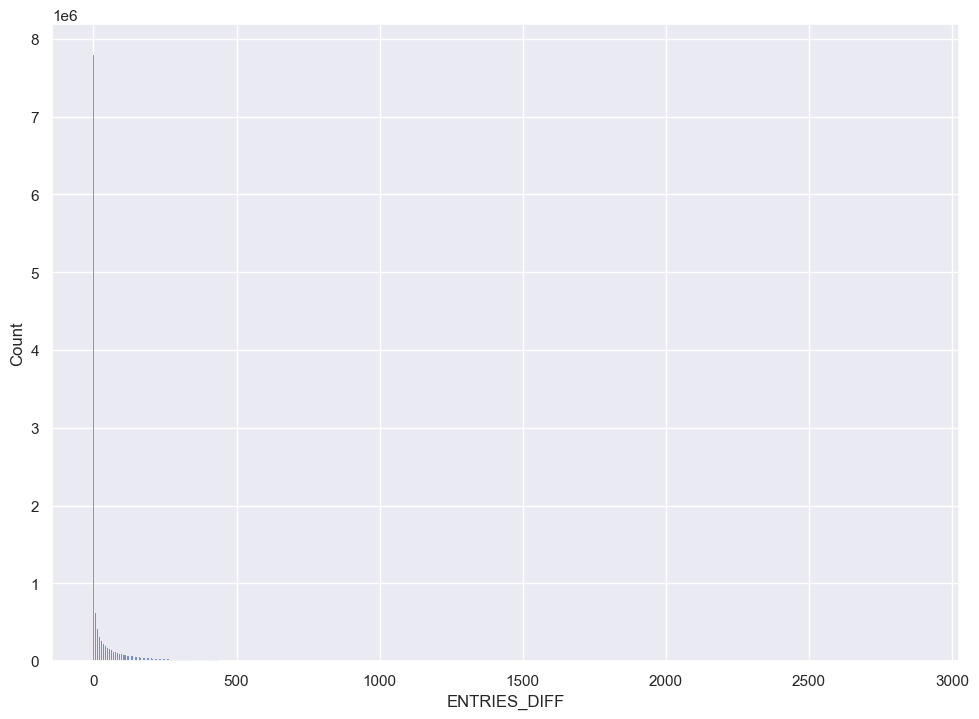

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(df["ENTRIES_DIFF"]);


In [30]:
df["EXITS_DIFF"] = df \
    .groupby(['STATIONLINE', 'C/A', 'UNIT', 'SCP'])['EXITS'] \
    .diff() \
    .fillna(0)


In [31]:
# rows where exits < 0
df.loc[df["EXITS_DIFF"] < 0, "EXITS_DIFF"]

4787        -82.0
4843        -51.0
4927        -19.0
4948        -21.0
4969        -40.0
            ...  
42956119   -279.0
42956139    -75.0
42956284   -205.0
42956609   -107.0
42956621   -199.0
Name: EXITS_DIFF, Length: 274046, dtype: float64

In [32]:
df.loc[df["EXITS_DIFF"] < 0, "EXITS_DIFF"]=0

In [33]:
# exits are prob more intense
sanity_check = 7200
df.loc[df["EXITS_DIFF"] > sanity_check, "EXITS_DIFF"] = 0

In [34]:
# keep rows with entries or exits > 0
df = df.loc[(df["ENTRIES_DIFF"] > 0) | (df["EXITS_DIFF"] > 0)].copy()

In [35]:
len(df)

37449403

<AxesSubplot: xlabel='EXITS_DIFF', ylabel='Count'>

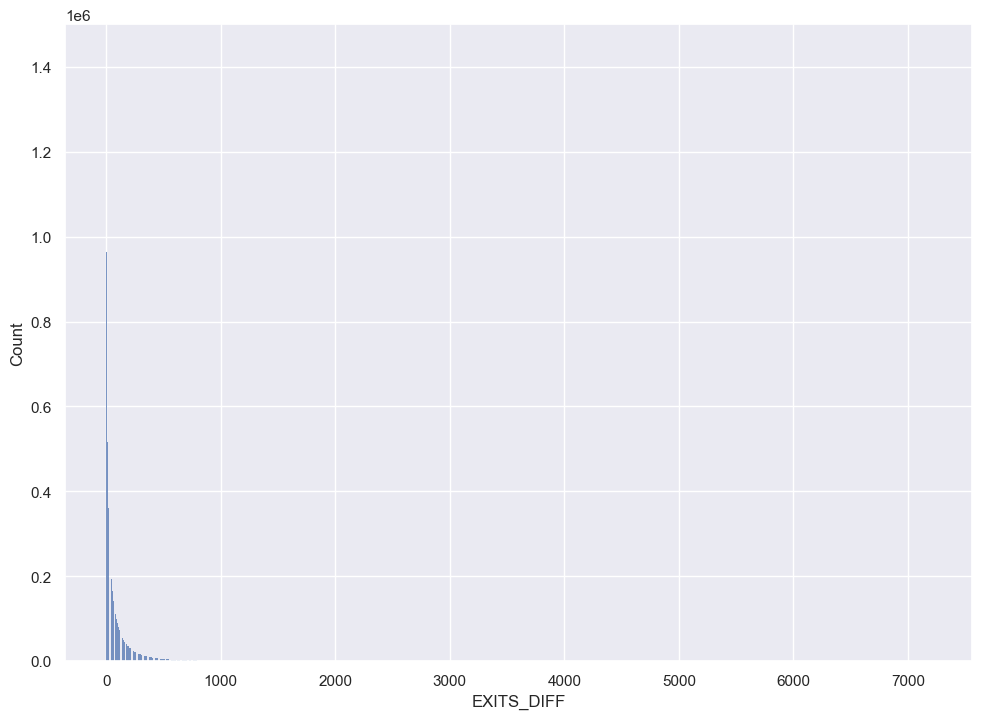

In [36]:
sns.histplot(df["EXITS_DIFF"])


In [37]:
df["DATE2"] = df["DATE_TIME"].dt.date

In [38]:
agg_time = df[["DATE2", "ENTRIES_DIFF"]] \
    .groupby(["DATE2"]) \
    .sum() \
    .reset_index()
agg_time["rolling"] = agg_time.rolling(7).sum()/7/1000000
agg_time


/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_55467/3345646176.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['DATE2'], dtype='object')
  agg_time["rolling"] = agg_time.rolling(7).sum()/7/1000000


,DATE2,ENTRIES_DIFF,rolling
0,2019-01-05,2408624.0,NaN
1,2019-01-06,2338588.0,NaN
2,2019-01-07,5369267.0,NaN
3,2019-01-08,5534388.0,NaN
4,2019-01-09,5660990.0,NaN
...,...,...,...
1444,2022-12-26,1194353.0,1.663411
1445,2022-12-27,1847822.0,1.587628
1446,2022-12-28,1990064.0,1.531868
1447,2022-12-29,2034425.0,1.513871


In [39]:
len(df)

37449403

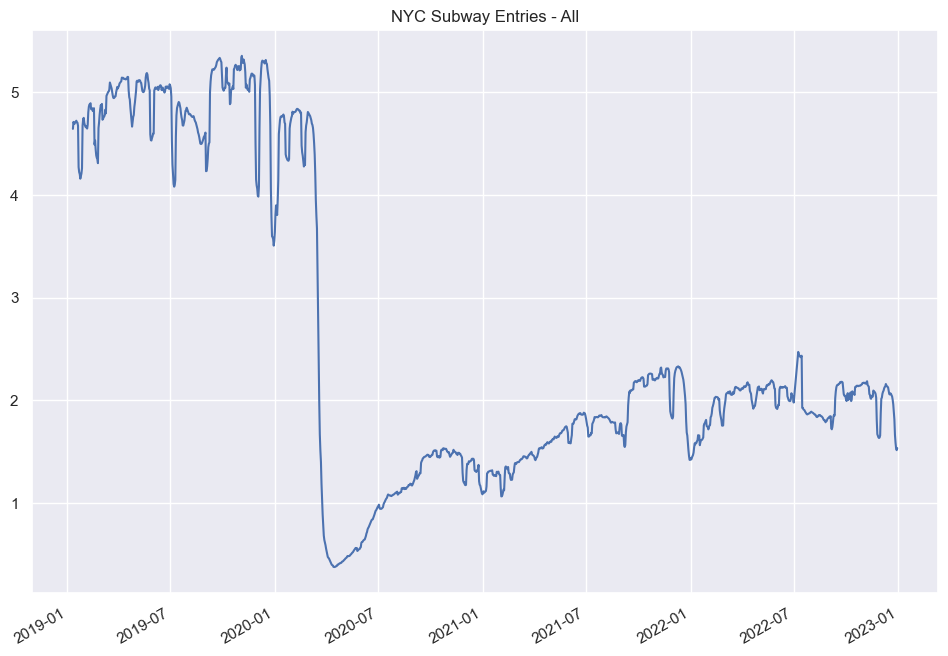

In [40]:
plt.plot(agg_time["DATE2"], agg_time["rolling"])
plt.title("NYC Subway Entries - All")
plt.gcf().autofmt_xdate();


In [41]:
df["STATIONLINE"].unique()

array(['103 ST-1', '103 ST-6', '103 ST-BC', '111 ST-A', '116 ST-23',
       '116 ST-6', '116 ST-BC', '116 ST-COLUMBIA-1', '125 ST-23',
       '125 ST-456', '135 ST-BC', '137 ST CITY COL-1', '14 ST-ACEL',
       '14 ST-UNION SQ-456LNQRW', '155 ST-BD', '155 ST-C', '157 ST-1',
       '163 ST-AMSTERDM-C', '170 ST-BD', '174 ST-25', '18 AV-N',
       '181 ST-A', '20 AV-N', '21 ST-G', '219 ST-25', '225 ST-25',
       '23 ST-1', '23 ST-6', '233 ST-25', '238 ST-1', '25 AV-D',
       '28 ST-1', '3 AV 138 ST-6', '33 ST-6', '36 ST-DNR', '36 ST-MR',
       '46 ST-MR', '52 ST-7', '57 ST-F', '61 ST WOODSIDE-7', '65 ST-MR',
       '66 ST-LINCOLN-1', '68ST-HUNTER CO-6', '69 ST-7', '7 AV-BDE',
       '7 AV-BQ', '7 AV-FG', '72 ST-123', '72 ST-2 AVE-Q', '77 ST-6',
       '79 ST-1', '8 AV-ACEL', '8 AV-N', '80 ST-A', '81 ST-MUSEUM-BC',
       '86 ST-1', '86 ST-2 AVE-Q', '86 ST-N', '88 ST-A', '9 AV-D',
       '96 ST-123', '96 ST-2 AVE-Q', '96 ST-6', 'ALABAMA AV-J',
       'ALLERTON AV-25', 'AQUEDUCT N.COND-A

In [42]:
cbd_stations = ['1 AV-L',
'14 ST-123FLM',
'14 ST-ACEL',
'14 ST-UNION SQ-456LNQRW',
'14TH STREET-1',
'18 ST-1',
'2 AV-F',
'23 ST-1',
'23 ST-6',
'23 ST-CE',
'23 ST-FM',
'23 ST-NRW',
'28 ST-1',
'28 ST-6',
'28 ST-NRW',
'3 AV-L',
'33 ST-6',
'34 ST-HERALD SQ-BDFMNQRW',
'34 ST-HUDSON YD-7',
'34 ST-PENN STA-123',
'34 ST-PENN STA-123ACE',
'34 ST-PENN STA-ACE',
'42 ST-BRYANT PK-7BDFM',
'42 ST-PORT AUTH-1237ACEGNRSW',
'42 ST-PORT AUTH-1237ACENQRSW',
'47-50 STS ROCK-BDFM',
'49 ST-NQRW',
'5 AV/53 ST-EM',
'5 AV/59 ST-NQRW',
'5 AVE-7BDFM',
'50 ST-1',
'50 ST-CE',
'50 ST-D',
'51 ST-6',
'57 ST-7 AV-NQRW',
'57 ST-F',
'59 ST COLUMBUS-1ABCD',
'59 ST-456NQRW',
'59 ST-NRW',
'6 AV-123FLM',
'7 AV-BDE',
'8 AV-ACEL',
'8 ST-NYU-NRW',
'9TH STREET-1',
'ASTOR PL-6',
"B'WAY-LAFAYETTE-6BDFQ",
'BLEECKER ST-6DF',
'BOWLING GREEN-45',
'BROAD ST-JZ',
'BROOKLYN BRIDGE-456JZ',
'CANAL ST-1',
'CANAL ST-6JNQRWZ',
'CANAL ST-ACE',
'CHAMBERS ST-123',
'CHAMBERS ST-23ACE',
'CHAMBERS ST-456JZ',
'CHRISTOPHER ST-1',
'CITY HALL-NRW',
'CORTLANDT ST-NRW',
'DELANCEY/ESSEX-FJMZ',
'EAST BROADWAY-F',
'EXCHANGE PLACE-1',
'FRANKLIN ST-1',
'FULTON ST-2345ACJZ',
'GRAND ST-BD',
'GRD CNTRL-42 ST-4567S',
'HOUSTON ST-1',
'LEXINGTON AV/53-6EM',
'LEXINGTON AV/63-F',
'PARK PLACE-23ACE',
'PATH NEW WTC-1',
'PATH WTC 2-1',
'PRINCE ST-NRW',
'RECTOR ST-1',
'RECTOR ST-NRW',
'SOUTH FERRY-1RW',
'SPRING ST-6',
'SPRING ST-CE',
'TIMES SQ-42 ST-1237ACENQRS',
'TIMES SQ-42 ST-1237ACENQRSW',
'TWENTY THIRD ST-1',
'W 4 ST-WASH SQ-ABCDEFM',
'WALL ST-23',
'WALL ST-45',
'WHITEHALL S-FRY-1RW',
'WORLD TRADE CTR-23ACE',
'WTC-CORTLANDT-1',
]


In [43]:
# manhattan < 66 st
# before 11am on weekday
cbd_df = df.loc[df["STATIONLINE"].isin(cbd_stations)]
len(cbd_df)

12749159

In [44]:
agg_time = cbd_df[["DATE2", "ENTRIES_DIFF"]] \
    .groupby(["DATE2"]) \
    .sum() \
    .reset_index()
agg_time["rolling"] = agg_time.rolling(7).sum()/7/1000000
agg_time


/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_55467/4150473774.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['DATE2'], dtype='object')
  agg_time["rolling"] = agg_time.rolling(7).sum()/7/1000000


,DATE2,ENTRIES_DIFF,rolling
0,2019-01-05,867057.0,NaN
1,2019-01-06,883932.0,NaN
2,2019-01-07,2091702.0,NaN
3,2019-01-08,2170443.0,NaN
4,2019-01-09,2227458.0,NaN
...,...,...,...
1444,2022-12-26,452648.0,0.583755
1445,2022-12-27,686363.0,0.564617
1446,2022-12-28,739148.0,0.552900
1447,2022-12-29,763722.0,0.557188


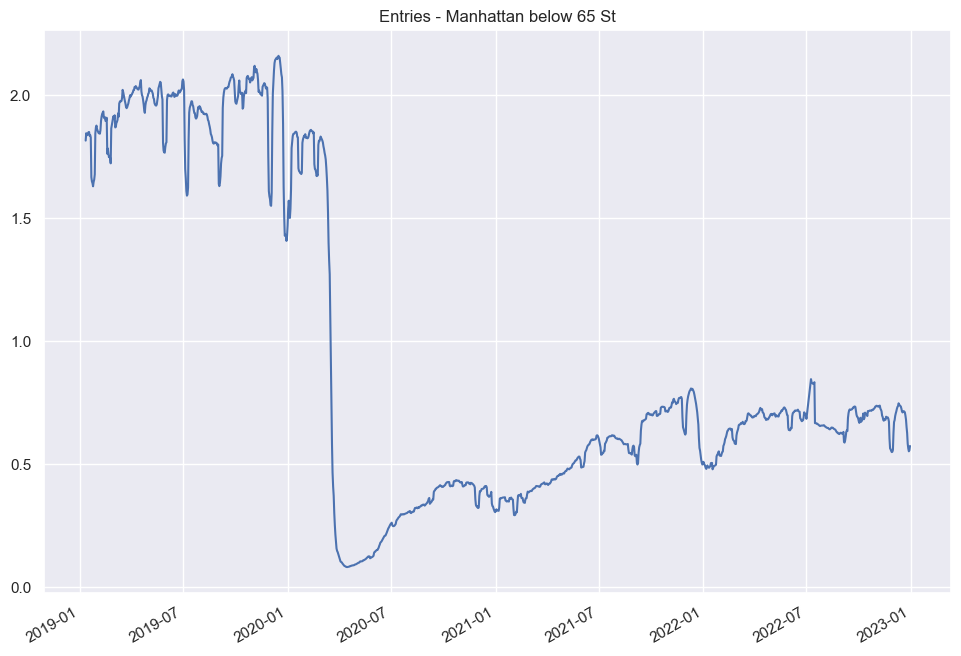

In [45]:
plt.plot(agg_time["DATE2"], agg_time["rolling"])
plt.title("Entries - Manhattan below 65 St")
plt.gcf().autofmt_xdate();


In [46]:
df["weekday"] = df["DATE_TIME"].dt.weekday
df["hour"] = df["DATE_TIME"].dt.hour

morn_df = df.loc[df["weekday"] < 5]
df_am = morn_df.loc[df["hour"] < 12]
df_am

,DATE_TIME,STATIONLINE,C/A,UNIT,SCP,ENTRIES,EXITS,ENTRIES_DIFF,EXITS_DIFF,DATE2,weekday,hour
57069,2019-01-07 00:00:00,103 ST-1,R170,R191,00-00-00,1654536,664689,193.0,119.0,2019-01-07,0,0
57070,2019-01-07 00:00:00,103 ST-1,R170,R191,00-00-01,13157553,3860965,116.0,54.0,2019-01-07,0,0
57071,2019-01-07 00:00:00,103 ST-1,R170,R191,00-00-02,16129305,4438410,129.0,61.0,2019-01-07,0,0
57072,2019-01-07 00:00:00,103 ST-1,R170,R191,00-03-00,8159305,4552475,109.0,88.0,2019-01-07,0,0
57073,2019-01-07 00:00:00,103 ST-1,R170,R191,00-03-01,12370551,9872883,160.0,177.0,2019-01-07,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42941741,2022-12-30 11:57:54,PATH NEW WTC-1-PTH,PTH22,R540,00-00-04,89836,96474,164.0,580.0,2022-12-30,4,11
42941742,2022-12-30 11:58:16,PAVONIA/NEWPORT-1-PTH,PTH06,R546,00-00-0A,312761,410382,99.0,119.0,2022-12-30,4,11
42941743,2022-12-30 11:58:36,HARRISON-1-PTH,PTH02,R544,00-06-01,4445,75127,36.0,10.0,2022-12-30,4,11
42941744,2022-12-30 11:58:56,JOURNAL SQUARE-1-PTH,PTH03,R552,00-00-03,328536,101662,379.0,13.0,2022-12-30,4,11


In [47]:
agg_ent = df_am[["DATE2", "ENTRIES_DIFF"]] \
    .groupby(["DATE2"]) \
    .sum() \
    .reset_index()
agg_ent["rolling"] = agg_ent.rolling(7).sum()/7/1000000
agg_ent

/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_55467/1739349272.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['DATE2'], dtype='object')
  agg_ent["rolling"] = agg_ent.rolling(7).sum()/7/1000000


,DATE2,ENTRIES_DIFF,rolling
0,2019-01-07,1717624.0,NaN
1,2019-01-08,1843771.0,NaN
2,2019-01-09,1870348.0,NaN
3,2019-01-10,1871540.0,NaN
4,2019-01-11,1784149.0,NaN
...,...,...,...
1030,2022-12-26,272992.0,0.642889
1031,2022-12-27,516676.0,0.615475
1032,2022-12-28,557125.0,0.593609
1033,2022-12-29,573628.0,0.567072


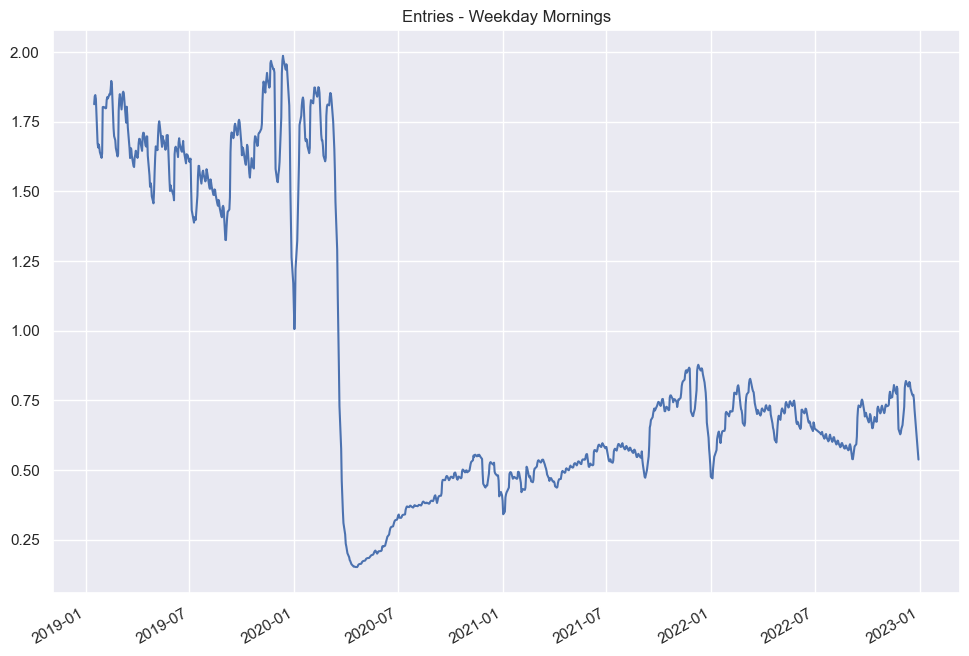

In [48]:
plt.plot(agg_ent["DATE2"], agg_ent["rolling"])
plt.title("Entries - Weekday Mornings")
plt.gcf().autofmt_xdate();


In [49]:
print ("%s Finished!" % (strftime("%H:%M:%S")))

16:09:19 Finished!
